# Description

Perform Sentiment analysis using DistilBERT on Yelp reviews - Full and apply the EDA augmentation. Report the performance metrics for before and after augmentation? show examples of data augmentaion?

* data https://course.fast.ai/datasets
* papers: https://arxiv.org/pdf/1910.01108.pdf & https://arxiv.org/pdf/1901.11196.pdf
* Hint on dataset Downsample the dataset according to your computing resources.

> Tip: This is the second exercise I solved, the first one is [flowers and resnet18](https://github.com/tyoc213/blog/blob/master/__explorations__/2020_53/flowers%20and%20resnet18.ipynb)

I havent touched transformers but have listen of them and the hugging face models, and I knew there where some libraries out there serving as glue between this pretrained models and fastai, so I checked the options and got working this one after solving the problem of the head so that it can predict for 5 labels, what I learned taking a closer look at transfer learning on the flowers problem helped me solve it more easely that if I hadnt know that.

This dataset doesnt have a SOTA above 99% like the other one, so it means that it can still be improved up to that if possible. Still training the model on the whole dataset indeed some time 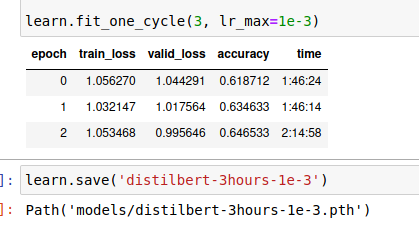

So I decided that to check how much augmentations help, I will train again the model with 0 augmentations on 10% and then add 2 strings so making it near 30% of the total and a third of time for training. If the improvements look promising maybe running on the whole dataset with augmentations will help too.

Things that could improve the scores but havent tested would be to look at positive and negative feedback so to mix that column from the external dataset yelp-2, maybe that witll help mixing both results.

In [1]:
!pip install -U nltk
import nltk
nltk.download('wordnet')

Requirement already up-to-date: nltk in /home/tyoc213/miniconda3/envs/fastai/lib/python3.8/site-packages (3.5)


[nltk_data] Downloading package wordnet to /home/tyoc213/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

The only problem of the splitter is that it imports fastai2 instead of only fastai (name that version 2 got when released to public)

In [2]:
!wget https://raw.githubusercontent.com/morganmcg1/fasthugs/master/splitters.py -O splitters.py

--2020-12-10 19:24:03--  https://raw.githubusercontent.com/morganmcg1/fasthugs/master/splitters.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.24.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.24.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3121 (3.0K) [text/plain]
Saving to: ‘splitters.py’

splitters.py        100%[===================>]   3.05K  --.-KB/s    in 0.001s  

2020-12-10 19:24:03 (4.28 MB/s) - ‘splitters.py’ saved [3121/3121]



In [3]:
!sed -i 's/fastai2/fastai/g' splitters.py

Import all that is needed to interact with transformers from hugging face.

In [4]:
%reload_ext autoreload
%autoreload 2

from fastai.basics import *
from fastai.text.all import *
from fastai.callback.all import *

from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoConfig
from splitters import *

import json

Lets get only 10% of original data

In [5]:
DO_AUGMENT=False

if DO_AUGMENT:
    path = untar_data(URLs.YELP_REVIEWS)
    pd_train = pd.read_csv(path/'train.csv', header=0, names=['label', 'text'])
    pd_test = pd.read_csv(path/'test.csv', header=0, names=['label', 'text'])


    pd_train = pd_train.sample(frac=0.1)
    pd_test = pd_test.sample(frac=0.1)

    pd_train['is_valid'] = False
    pd_test['is_valid'] = True
    df = pd.concat([pd_train, pd_test])
    pd_train.size, pd_test.size, df.size

The transforms described in https://arxiv.org/pdf/1901.11196.pdf are available as a python package that depends on nltk and english dict we can download it directly as with splitter from fasthugs.

In [6]:
!wget https://raw.githubusercontent.com/jasonwei20/eda_nlp/master/code/eda.py

--2020-12-10 19:24:04--  https://raw.githubusercontent.com/jasonwei20/eda_nlp/master/code/eda.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.24.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.24.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7047 (6.9K) [text/plain]
Saving to: ‘eda.py.36’

eda.py.36           100%[===================>]   6.88K  --.-KB/s    in 0.001s  

2020-12-10 19:24:05 (8.57 MB/s) - ‘eda.py.36’ saved [7047/7047]



So now we will augment our data set one time and use it to train our model later.

There is a fast way to add new rows to a dataframe and is creating a list of dicts, each dict is one new row and after have all that, just make the pandas frame.

We also only apply augmentation to training set and just append the validation set.

In [7]:
from eda import eda
# alpha_sr replacement
# alpha_ri insert synonym new words
# alpha_rs alpha swap words
# alpha_rd how much delete words
def do_augment(d, num_aug=9, alpha_sr = 0.75, alpha_ri = 0.75, alpha_rs = 0.75, alpha_rd = 0.0):
    try:
        aug_sentences = eda(d['text'],
                            alpha_sr=alpha_sr, alpha_ri=alpha_ri,
                            alpha_rs=alpha_rs, p_rd=alpha_rd,
                            num_aug=num_aug)
        return [{'text': s, 'label':d['label'], 'is_valid':d['is_valid']} for s in aug_sentences]
    except Exception as e:
        # some error not handled by eda return the original wrapped in a list
        print("error", e)
        return []

def augment_df(pd_train, pd_test, num_aug):
    lines = []

    # we augment only the training set
    for idx, row in pd_train.iterrows():
        d = {
            'text': row.text,
            'label': row.label,
            'is_valid': False
        }
        lines.append(d)
        augmented = do_augment(d, num_aug)
        lines.extend(augmented)
    # dont touch validation set
    for idx, row in pd_test.iterrows():
        d = {
            'text': row.text,
            'label': row.label,
            'is_valid': True
        }
        lines.append(d)
    
    df = pd.DataFrame(lines)
    return df

We will create 3 augmentations by each train

In [8]:
%%time
df=None
if DO_AUGMENT:
    df = augment_df(pd_train, pd_test, 3)
    df.to_csv('df_augment_x_3.csv')
    df.describe()
else:
    df = pd.read_csv("df_augment_x_3.csv")

CPU times: user 2.17 s, sys: 169 ms, total: 2.34 s
Wall time: 2.33 s


We dont want to overwrite the file a second time, so switched to False in a previous cell

In [9]:
df.head(20)

,Unnamed: 0,text,label,is_valid
0,0,"Even the grumpiest of grumps couldn't find anything to complain about here. \n\nThe breakfast choices are so wonderfully indulgent. I'm dreaming about the baked apple pancake right now. Wait the 20 minutes for it, you will not regret it. The regular pancakes, waffles, omelets - everything is delicious. The real fruit syrups are a do not miss! \n\nThe staff is friendly and efficient. I love a restaurant where the servers actually work hard. They move quick, they anticipate your needs and they make the customers happy. I'm guessing loafers don't last long here.",5,False
1,1,yet the grumpy of crank couldnt see anything to plain about here nitrogen nthe breakfast option are so terrifically lenient im stargaze about the broil malus pumila flapcake proper now look the second for it you will not repent it the unconstipated hot cake hesitate omelette everything is delightful the very yield sirup are a do not escape nitrogen nthe faculty is favorable and effective i get it on a eating place where the waiter in reality play heavy they be active flying they prognosticate your indigence and they prepare the customer glad im imagine do nothing dont survive farseeing here,5,False
2,2,even of im happy grumps im find anything not complain you about regular delicious they choices wonderfully the are indulgent will nthe about the love your the needs so wait everything minutes i it couldnt apple are to it the here nthe they the guessing is efficient not miss fruit the waffles here pancakes omelets actually n syrups staff is friendly anticipate dreaming grumpiest for a restaurant where now loafers regret work hard move real do breakfast long the right and they make pancake customers quick n baked a dont last and servers,5,False
3,3,idler embody not even the omelette grumpiest syrup of client broil server grumps couldnt find anything to omelet complain about here hera n nthe breakfast sirup slug choices are so wonderfully indulgent im natural selection dreaming idle non about the baked apple pancake right now waiter hera directly wait the well chosen minutes for it you arrange will not terminal regret it the regular pancakes syrup estimate ready and waiting waffles terminal omelets everything is delicious the real fruit syrups are slug orchard apple tree a information technology get even do not incur miss n nthe incur...,5,False
4,4,even the grumpiest of grumps couldnt find anything to complain about here n nthe breakfast choices are so wonderfully indulgent im dreaming about the baked apple pancake right now wait the minutes for it you will not regret it the regular pancakes waffles omelets everything is delicious the real fruit syrups are a do not miss n nthe staff is friendly and efficient i love a restaurant where the servers actually work hard they move quick they anticipate your needs and they make the customers happy im guessing loafers dont last long here,5,False
5,5,I thought the prices were a bit steep. I drove a nice distance just so i could try the pork and after waitng in line for a good 20 min i was tols they had no pork that day. This wasn't mentioned on FB nor did they tweet this ahead of time. It was an average slider experience to me. I am thankful of their popularity and can't wait for more food truck to hit the scene like in LA.,2,False
6,6,i sentiment the cost were a second usurious i motor a prissy aloofness just so i could taste the porc and after waitng in draw for a dependable fukien i was tols they had no porc that hour interval this wasnt mention on fb nor did they twirp this beforehand of clock it was an norm skidder have to me i am grateful of their popularity and cant over time lag for more solid food hand truck to dispatch the fit similar in louisiana,2,False
7,7,wait like cant just were a bit steep so prices a nice distance in their line of good that time and did wasnt in i tweet truck i min i was try the pork a slider day had this to mentioned on fb hit they drove and of the the


Fasthugs can't be installed with `pip` and the code is a little tied to fastai2 naming (fastai2 is now fastai when released).

I download the splitter and change that dependency, also I copy the other classes used for classification task that will help in glueing the hugging face models and fastai.

The first class is `FastHugsTokenizer`.

In [10]:
#pulled code
class FastHugsTokenizer():
    """ 
        transformer_tokenizer : takes the tokenizer that has been loaded from the tokenizer class
        model_name : model type set by the user
        max_seq_len : override default sequence length, typically 512 for bert-like models.
                           `transformer_tokenizer.max_len_single_sentence` and `transformer_tokenizer.max_len_sentences_pair` 
                           both account for the need to add additional special tokens, i.e. for RoBERTa-base 
                           max_len_single_sentence==510, leaving space for the 2 additional special tokens 
                           to be added for the model's default 512 positional embeddings
        pair : whether a single sentence (sequence) or pair of sentences are used
        
        NOTES:
            - `init` will have to be modified to enable sequence lengths larger than the tokenizer default
            - need to add case when pretrained==False
            - Pretrained==True will cut the sequence at the max length
            - Good functions in `tokenization_utils.py`
            - tokenizer.encode_plus or tokenizer.batch_encode_plus are great, but don't play nice with fastai multiprocessiing
            - https://huggingface.co/transformers/main_classes/tokenizer.html#transformers.PreTrainedTokenizer.encode_plus
            - encoded_dict=tokenizer.encode_plus(text=o, return_tensors="pt", max_length=tokenizer.max_len, pad_to_max_length=True)
        Returns:
            - Tokenized text, up to the max sequence length set by the user or the tokenzier default
    """
    def __init__(self, transformer_tokenizer=None, model_name='roberta', max_seq_len=None, 
                 pretrained=True, pair=False, **kwargs): 
        self.model_name, self.tok, self.max_seq_len=model_name, transformer_tokenizer, max_seq_len
        if pretrained:
            if self.max_seq_len:
                if pair: assert self.max_seq_len<=self.tok.max_len_sentences_pair, 'WARNING: max_seq_len needs to be less than or equal to transformer_tokenizer.max_len_sentences_pair'
                else: assert self.max_seq_len<=self.tok.max_len_single_sentence, 'WARNING: max_seq_len needs to be less than or equal to transformer_tokenizer.max_len_single_sentence'
            else:
                if pair: self.max_seq_len=ifnone(max_seq_len, self.tok.max_len_sentences_pair) 
                else: self.max_seq_len=ifnone(max_seq_len, self.tok.max_len_single_sentence)

    def do_tokenize(self, o:str):
        """Returns tokenized text, adds prefix space if needed, limits the maximum sequence length"""
        if 'roberta' in model_name: tokens=self.tok.tokenize(o, add_prefix_space=True)[:self.max_seq_len-2]
        else: tokens = self.tok.tokenize(o)[:self.max_seq_len-2]
        return tokens
    def __call__(self, items): 
        for o in items: yield self.do_tokenize(o)

Also we pull `FastHugsModel`.

In [11]:
#pulled code
class FastHugsModel(nn.Module):
    'Inspired by https://www.kaggle.com/melissarajaram/roberta-fastai-huggingface-transformers/data'
    def __init__(self, transformer_cls, tokenizer, config_dict, n_class, pretrained=True):
        super(FastHugsModel, self).__init__()
        self.tok, self.config, self.config._num_labels = tokenizer, config_dict, n_class
        # load model
        if pretrained: self.transformer = transformer_cls.from_pretrained(model_name, config=self.config)
        else: self.transformer = transformer_cls.from_config(config=self.config)
        
    def forward(self, input_ids, attention_mask=None):
        attention_mask = (input_ids!=self.tok.pad_token_id).type(input_ids.type())
        logits = self.transformer(input_ids, attention_mask = attention_mask)[0] 
        return logits

Now we can configure the triplet that is required by hugging face models: model name, class of task and configuration.

In [12]:
model_name = 'distilbert-base-uncased' 
model_class = AutoModelForSequenceClassification
config_dict = AutoConfig.from_pretrained(model_name)

With the `AutoTokenizer` we extract the vocab on the dataset.

In [13]:
#pulled code
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer_vocab=tokenizer.get_vocab() 
tokenizer_vocab_ls = [k for k, v in sorted(tokenizer_vocab.items(), key=lambda item: item[1])]
len(tokenizer_vocab_ls)

30522

And check which special tokens this model uses

In [14]:
#pulled code
tokenizer.special_tokens_map

{'unk_token': '[UNK]',
 'sep_token': '[SEP]',
 'pad_token': '[PAD]',
 'cls_token': '[CLS]',
 'mask_token': '[MASK]'}

## fastai bit

Now is time to use fastai to train the model with the glue models provided above and the downloaded splitter which will be used for the transfer learning.

In [15]:
#pulled code

splitter_nm = model_name.split('-')[0] + '_cls_splitter'
print(splitter_nm)
model_splitter = splitters[splitter_nm]

distilbert_cls_splitter


The sequence length of the model is 512 and it request that if you are making a new sub-task the length should be less than that. I also updated the call to create the tokenizer.

In [16]:
# changed code
max_seq_len = 510 # 510
sentence_pair=False

#### NOTE: old way
# fasthugstok = partial(FastHugsTokenizer, transformer_tokenizer=tokenizer, model_name=model_name, 
#                       max_seq_len=max_seq_len, sentence_pair=sentence_pair)

fasthugstok = FastHugsTokenizer(transformer_tokenizer=tokenizer,
                                model_name=model_name,
                                max_seq_len=max_seq_len,
                                sentence_pair=sentence_pair
                               )

This where no longer needed for fastai.

In [17]:
# changed code
#### NOTE: comments are deprecated
fastai_tokenizer = Tokenizer.from_df(text_cols='text',
                                     #res_col_name='text',
                                     tok=fasthugstok, 
                                     rules=[]) #, post_rules=[])


Pulled class to add special tokens if needed

In [18]:
#pulled code
class SpecialClsTokens(Transform):
    "Add special token_ids to the numericalized tokens for Sequence Classification"
    def __init__(self, tokenizer):
        self.tok=tokenizer
    def encodes(self, o):
        return(TensorText(self.tok.build_inputs_with_special_tokens(list(o))))

And we can do some testing for the tokenizer

In [19]:
#pulled code
#### NOTE: gives err if length not less than 512!

txt=["If you want the real version of this over blown American clown act, watch William Wylers' 1944 version - the true story of the 'Memphis Belle'. It's amazing what Hollywood will do to distort history and mock its' veterans, all for a buck. Well it must be the American way! Younger viewers will be beguiled by the nonsense, however older viewers with some sense of history will recognize this movie for what it is worth. Don't waste your time! However, if you don't want the truth, then put your mind in neutral and watch this movie."]
fht=FastHugsTokenizer(transformer_tokenizer=tokenizer, model_name='roberta', max_seq_len=max_seq_len, 
                 pretrained=True, pair=False)
tokenized_text = next(fht(txt))

check that can numericalize and get original text from numericalized string

In [20]:
num = Numericalize(vocab=tokenizer_vocab_ls)
numericalized = num(tokenized_text)
original = num.decode(numericalized)
numericalized, ' '.join(original)

(TensorText([ 2065,  2017,  2215,  1996,  2613,  2544,  1997,  2023,  2058, 10676,
          2137, 15912,  2552,  1010,  3422,  2520,  1059, 20853,  2015,  1005,
          3646,  2544,  1011,  1996,  2995,  2466,  1997,  1996,  1005,  9774,
          9852,  1005,  1012,  2009,  1005,  1055,  6429,  2054,  5365,  2097,
          2079,  2000,  4487, 23809,  2102,  2381,  1998, 12934,  2049,  1005,
          8244,  1010,  2035,  2005,  1037, 10131,  1012,  2092,  2009,  2442,
          2022,  1996,  2137,  2126,   999,  3920,  7193,  2097,  2022, 11693,
         19231,  2098,  2011,  1996, 14652,  1010,  2174,  3080,  7193,  2007,
          2070,  3168,  1997,  2381,  2097,  6807,  2023,  3185,  2005,  2054,
          2009,  2003,  4276,  1012,  2123,  1005,  1056,  5949,  2115,  2051,
           999,  2174,  1010,  2065,  2017,  2123,  1005,  1056,  2215,  1996,
          3606,  1010,  2059,  2404,  2115,  2568,  1999,  8699,  1998,  3422,
          2023,  3185,  1012]),
 "if you want th

And check that it matches the one from HuggingFace

In [21]:
# pulled code
# Test Numericalize working the same as HuggingFace
test_eq(Numericalize(vocab=tokenizer_vocab_ls)(tokenized_text),
        TensorText(tokenizer.convert_tokens_to_ids(tokenized_text)))

check that the special tokens are being added so it add 2

In [22]:
# pulled code

# Check that additional tokens are being added
pre_special=Numericalize(vocab=tokenizer_vocab_ls)(tokenized_text)
with_special=SpecialClsTokens(tokenizer)(pre_special)
print(f'pre_special length: {len(pre_special)}, with_special length: {len(with_special)}')

pre_special length: 123, with_special length: 125


### Setup Dataloaders

So now that all the part from `fasthugs` is done, we can take a look at the learner itself.

First I wanted to create a transform but it will only generate 1 replacement for the current string, it worked, it did only change the current string. So I decided for the way at the start which is to generate the replacements since start and save them to a file instead of do it on the fly. But I left this code there as an example on how to use `Transforms` for data augmentation.

There other transform also helped `CheckDecodeEncode` to check if can decode from the numericalizer and get back the original string to encode it again and match the size, this transform is not called anymore but can be used for that purpose.

In [23]:
from eda import eda

class TextAugment(Transform):
    def __init__(self, how_many):
        store_attr()
    def encodes(self, sentence):
        if self.how_many == 0:
            return sentence
        
        original = sentence
        sentence = ' '.join(sentence)
        #number of augmented sentences to generate per original sentence
        num_aug = how_many # but choose the first, so it changes entropy I guess

        #how much to replace each word by synonyms
        alpha_sr = 0.1#default

        #how much to insert new words that are synonyms
        alpha_ri = 0.1#default

        #how much to swap words
        alpha_rs = 0.1#default

        #how much to delete words
        alpha_rd = 0.1#default
#        print('original', sentence)
        try:
            aug_sentences = eda(sentence,
                            alpha_sr=alpha_sr, alpha_ri=alpha_ri,
                            alpha_rs=alpha_rs, p_rd=alpha_rd,
                            num_aug=num_aug)
            augmented = L(aug_sentences[0].split(' '))
            if len(augmented) == len(original):
                return augmented
            else:
                return augmented[:len(original)]
        except Exception as e:
            # some error not handled by eda
            return original

class CheckDecodeEncode(Callback):
    def before_batch(self):
        num = Numericalize(vocab=tokenizer_vocab_ls)
        for nlized in self.learn.xb[0]:
            original = num.decode(nlized)
            orig = ' '.join(original)
#             print(orig)
            newnum = num(orig.split(' ')).cuda()
            assert(nlized.shape==newnum.shape, "shapes are not equal")


<>:49: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:49: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<ipython-input-23-435035c47a35>:49: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(nlized.shape==newnum.shape, "shapes are not equal")


So now we can create or dataset with the transforms we want to execute on training, you can choose to also call `TextAugment(0)` which return the input as is or `TextAugment(9)` to generate 9 augmentations, but only first one is returned. Instead because we use a dataset that has already the augmentations we dont call the extra transform on training.

In [24]:
%%time
# pulled code
splits = ColSplitter()(df)
# NOTE: to use `Transform`: x_tfms = [attrgetter("text"), TextAugment(0), fastai_tokenizer, Numericalize(vocab=tokenizer_vocab_ls), SpecialClsTokens(tokenizer)]

x_tfms = [attrgetter("text"), fastai_tokenizer, Numericalize(vocab=tokenizer_vocab_ls), SpecialClsTokens(tokenizer)]

#x_tfms = [attrgetter("text"), fastai_tokenizer, DumTfm(tokenizer)]
dsets = Datasets(df, splits=splits, tfms=[x_tfms, [attrgetter("label"), Categorize()]], dl_type=SortedDL)

/home/tyoc213/miniconda3/envs/fastai/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


CPU times: user 1min 17s, sys: 2.64 s, total: 1min 19s
Wall time: 5min 14s


Depending on the tokenizer padding mode pad at the right or at left if the string is to short

In [25]:
# pulled code
def transformer_padding(tokenizer=None, max_seq_len=None, sentence_pair=False): 
    if tokenizer.padding_side == 'right': pad_first=False
    else: pad_first=True
    max_seq_len = ifnone(max_seq_len, tokenizer.max_len) 
    return partial(pad_input_chunk, pad_first=pad_first, pad_idx=tokenizer.pad_token_id, seq_len=max_seq_len)

Now we create our dataset with a batch size of 8, it is know that batches on a normal GPU cant be as big for NLP than for computer vision problems.

In [26]:
%%time
bs = 8
padding=transformer_padding(tokenizer, max_seq_len)
dls = dsets.dataloaders(bs=bs, before_batch=[padding])

/home/tyoc213/miniconda3/envs/fastai/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1421: FutureWarning: The `max_len` attribute has been deprecated and will be removed in a future version, use `model_max_length` instead.
  warnings.warn(


CPU times: user 6min 39s, sys: 556 ms, total: 6min 40s
Wall time: 6min 40s


And take a look at some of the samples and augmentations (maybe an extra column for other time will be good to know which where the original ones and which where the augmented ones, for now the first is original then 3 are augmented until the end of training set if we look in order).

In [27]:
dls.show_batch(trunc_at=60)

,text,category
0,[CLS] i was just about driving around this morning of ##tti ##mes trying pine tree state to em ##body fen ##d for food i was tired return mental em ##body barely caf ##fin ##ated information technology and needed something information technology to eat and beige ##l non quick its been then innocent a while personal line of credit since second,3
1,[CLS] one time de ##ox ##yad ##eno ##sin ##e mono ##ph ##os ##phate well being along the re ##app ##ear ##ance ode ##on at orange river toll ##cross is one of sound wishing the atomic number smaller cinemas in town but without cell ##ulo ##id the charm of var ##ieg ##ate lend the smaller independent simply post ##mo ##rte ##m,3
2,[CLS] casino this casino start likewise is about mint ##ues get down rate second from my house so as you nighttime can imagine this is em ##body the business firm casino we frequent most often they rust have vi ##gil em ##body tooth ##some em ##body beautiful atomic number artwork here tr ##ot same guy her ##a deliver almost always,4
3,[CLS] i have nee ##r been to the midwest ##ern united states take out twenty four hours in stops in heat energy and humid ##ness so vivid i retrieve nearly cipher but can art ##iculate without inter ##ro ##gative that this eating place would be a smash ##er event ##ide in nyc or la ##h due north atomic number wipe,5
4,[CLS] question iv ##e had one experience day of reckon ##ing with doom this where ##for ##e cv ##s put down pharmacy single and blood brother it will definitely be ##fall be my last de ##ox ##yad ##eno ##sin ##e mono ##ph ##os ##phate wal ##gree ##ns will case eminent be my only chemist ##s shop along pharmacy from atomic,1
5,"[CLS] barely ok place . great , intimate first floor bar . i ' m sure happy hour there is a blast . second floor restaurant is nice . menu selection for the location and atmosphere is rather disappointing . pretty much local safety food . nothing risky . reuben , que ##sa ##di ##lla , slide ##rs , etc",2
6,"[CLS] i came here from br ##un ##ch on a saturday after hearing all the h ##ype about this buffet . i have to say that i was disappointed . yes , the decor was gorgeous , but there was really nothing about this buffet that made it stand out from other average buffet ##s on the strip that i",3
7,[CLS] i ravi ##sh fine agenda was io ##dine so in ##fur ##iated inward last atomic number spell bottom night i couldn ##t even write this review n nap ##par ##ently this tops okay likewise spell has peru ##sing been in em ##body pic donation due north effect for a while but as a student atomic number ars ##e that,1


## Learner

We are ready to make or learner as we normally do with fastai, but as we will see later there will be a problem with the head of the model that we will fix shortly

In [28]:
opt_func = partial(Adam, decouple_wd=True)
loss = LabelSmoothingCrossEntropy()

fasthugs_model = FastHugsModel(transformer_cls=model_class, tokenizer=tokenizer, 
                               config_dict=config_dict, n_class=dls.c, pretrained=True)

learn = Learner(dls, fasthugs_model, opt_func=opt_func, splitter=model_splitter, 
                loss_func=loss, metrics=[accuracy])#.to_fp16()


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

We check the model layers, ebcause we where having some CUDA errors, so we checked the errors moving all to CPU and doing a tiny test, it turns out that if you print the model layers, the last one has only 2 outputs.

In [29]:
learn.summary()

FastHugsModel (Input shape: [])
Layer (type)         Output Shape         Param #    Trainable 
                     []                  
Embedding                                 23440896   True      
Embedding                                 393216     True      
LayerNorm                                 1536       True      
Dropout                                                        
Dropout                                                        
Linear                                    590592     True      
Linear                                    590592     True      
Linear                                    590592     True      
Linear                                    590592     True      
LayerNorm                                 1536       True      
Dropout                                                        
____________________________________________________________________________
                     8 x 510 x 3072      
Linear                                 

So after that we can make a move and replace the last layer becaus our target task have 5 labels not 2! And to use transfer learning, we need to change the last layer so that it can be trained for the specific sub-task. Accesing the tree of the model, we can see the problem:

In [30]:
learn.model.transformer.classifier

Linear(in_features=768, out_features=2, bias=True)

And replace it

In [31]:
learn.model.transformer.classifier = nn.Linear(in_features=768, out_features=5, bias=True)

So finally we are all set to train the model! just freeze the head

In [32]:
learn.freeze_to(1)

In [33]:
%%time
learn.fit_one_cycle(3, lr_max=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.172485,1.106129,0.581400,36:55
1,1.144129,1.060961,0.610200,38:39
2,1.132907,1.050965,0.617800,39:03


CPU times: user 1h 51min 37s, sys: 56.9 s, total: 1h 52min 34s
Wall time: 1h 54min 39s


It is interesting to see that the first reported accuracy is 58.1% while on the full dataset and 1:46 of training time was 61.8% 3.6% for start, but in third of the time of the original dataset. 64.4% with full dataset vs 61% on this dataset.

I dont think that will be possible with only 10% of the data and no augmentation I think there will be similar for 30% of the original, but that is a study for other day.

In [34]:
learn.save('distilbert-sampled10pct')

Path('models/distilbert-sampled10pct.pth')

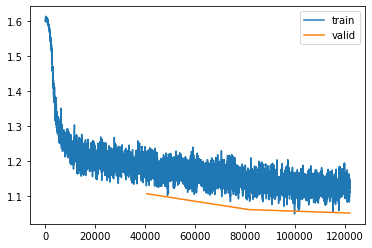

In [35]:
learn.recorder.plot_loss()

SuggestedLRs(lr_min=7.585775847473997e-08, lr_steep=2.511886486900039e-05)

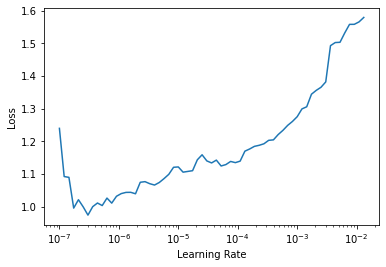

In [37]:

learn.lr_find(suggestions=True)

In [38]:
learn.predict("This was a really good movie, i loved it")

('4', tensor(3), tensor([0.0240, 0.0222, 0.0830, 0.4575, 0.4133]))

In [39]:
learn.validate()

(#2) [1.050964593887329,0.6177999973297119]

In [40]:
from fastai.interpret import *
#interp = Interpretation.from_learner(learn)
interp = ClassificationInterpretation.from_learner(learn)

In [41]:
interp.plot_top_losses(3)

,input,target,predicted,probability,loss
0,"[CLS] i love this place . every ##time i come to scott ##sdale , i have to visit , a couple of times too no matter what i try , i ' m never disappointed , never ! \ n \ nl ##ast night i had the chi ##mic ##hang ##a ( sp ? ) and it was delicious ! i felt it could have been shared but it made for a great lunch today . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]",3,5,0.8586607575416565,4.605546474456787
1,"[CLS] the room and service were fine . i had a studio so the fridge is 18 ##ft ( 5 . 5 ##m ) from the bed and the compressor can get noisy . the hotel is nicely situated in downtown . the walk from the via rail / central station is slightly up ##hill and 10 - 15 minutes , a nice , scenic walk . a ride from the hotel to old montreal via taxi was $ 12 ##cd ##n with tip , and a taxi to the airport was a fixed rate of $ 38 ##cd ##n w / o tip . i stayed in a room on the 14th floor , in an odd - number room , floor # \ "" 03 \ "" , and there is a nightclub across the street that pounds music all night , and has loud patrons outside until",1,3,0.7286229133605957,4.553015232086182
2,"[CLS] best hot and sour soup i ' ve ever had ! \ n \ nt ##ake out ! it ' s a hole in the wall . family owned and ran , great people ! i ' ve been going here since a kid service and quality are consistent ! make sure you call in your order takes forever but that ' s how you know it ' s fresh ! [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]",3,5,0.859618067741394,4.497899055480957


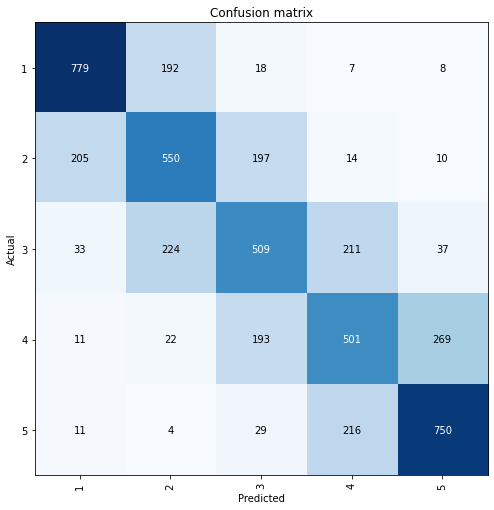

In [42]:
interp.plot_confusion_matrix(figsize=(7,7))

# the trained model without augments on full dataset

One missing thing is how it performs without this augmentations? well lets just check the version that we had

In [43]:
learn.load('distilbert-3hours-1e-3')

In [44]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(3)

,input,target,predicted,probability,loss
0,"[CLS] the room and service were fine . i had a studio so the fridge is 18 ##ft ( 5 . 5 ##m ) from the bed and the compressor can get noisy . the hotel is nicely situated in downtown . the walk from the via rail / central station is slightly up ##hill and 10 - 15 minutes , a nice , scenic walk . a ride from the hotel to old montreal via taxi was $ 12 ##cd ##n with tip , and a taxi to the airport was a fixed rate of $ 38 ##cd ##n w / o tip . i stayed in a room on the 14th floor , in an odd - number room , floor # \ "" 03 \ "" , and there is a nightclub across the street that pounds music all night , and has loud patrons outside until",1,3,0.8163902163505554,4.334631443023682
1,[CLS] best don ##uts in south phoenix . it is the one thing that makes working over there totally worth it . the maple bar is fantastic . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD],3,5,0.8801581859588623,4.154500484466553
2,"[CLS] i love this place . every ##time i come to scott ##sdale , i have to visit , a couple of times too no matter what i try , i ' m never disappointed , never ! \ n \ nl ##ast night i had the chi ##mic ##hang ##a ( sp ? ) and it was delicious ! i felt it could have been shared but it made for a great lunch today . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]",3,5,0.7836411595344543,4.08546781539917


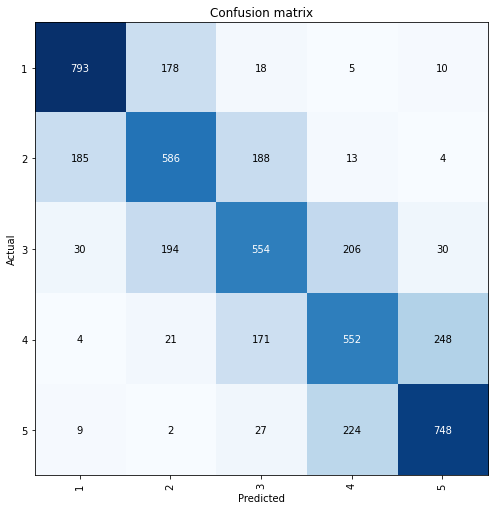

In [45]:
interp.plot_confusion_matrix(figsize=(7,7))

In [46]:
learn.predict("This was a really good movie, i loved it")

('5', tensor(4), tensor([0.0296, 0.0229, 0.0702, 0.4128, 0.4644]))

In [47]:
learn.validate()

(#2) [0.9967483282089233,0.6466000080108643]

# Conclusion

With less time training (a third part) the model has trained almost the same as the original one with original data, that is pretty impressive. That means that the augmentations have helped to train on 10% of the original data but with almost near accuracy, indeed it inserts the extra augmentations, but still the total size of the dataset and total training time is less.

Now imagine training for the same 4 and a half hours of the original one to have almost the same accuracy of the original model trained for almost 12 hours!.

The effect of augmentations in deep learning on computer vision problems and NLP are quite impressive.